In [465]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from scipy.stats.mstats import gmean
from matplotlib.patches import Patch, Rectangle
from matplotlib.collections import PatchCollection, LineCollection
import matplotlib.lines as lines
import math
from scipy.interpolate import interp1d


import os
from plot_utils import COLORS, get_exp_label, get_ci_size, save_plot, update_width, add_labels, get_upper_ci_size,remove_outliers_df_grouped
from plot_utils_v2 import remove_outliers_df_iqr_grouped

import matplotlib.ticker as ticker

sns.set_style("white", {"ytick.left": True})
plt.rcParams["font.family"] = ["Latin Modern Roman Demi 10 Regular"]
plt.rcParams['font.family'] = 'Arial'

plt.rcParams['hatch.linewidth'] = 0.3
plt.rcParams['axes.labelpad'] = 5 
PALETTE = [COLORS["peach2"], COLORS["g1"]]
PALETTE_B = ["#CEF0D2", "#C8FCB6", "#96DE9B", "#66B784", "#469E7B"]
HATCHES = ["/" * 3, "\\" * 3, "/" * 3, "\\" * 3, "/" * 3]
%config InlineBackend.figure_format = 'retina'

MY_PALETTE = [c.lower() for c in ["#C2801B","#C73625","#AD5CB3","#4CD6A0","#1E99DF"]]
COLOR_PALETTE = ['#7bd490', '#C6E6DB', '#FA4D4A']



In [466]:
GRAPH_NAMES = {
    "web-NotreDame": "WB-ND",
    "wiki-Talk": "WB-TA",
    "web-Google": "WB-GO",
    "web-BerkStan": "WB-BE",
    "flickr": "FL",
    "italy_osm": "IT",
    "patents": "PA",
    "venturiLevel3" :"VL3",
    "germany_osm": "DE",
    "asia_osm": "ASIA",
    "road_central": "RC",
    "wikipedia-20070206": "WK",
    "hugetrace-00020": "HT",
    "wb-edu": "WB",
    "hugebubbles-00010": "HB",
    "soc-LiveJournal1": "LJ",
    "GAP-kron": "KRON",
    "GAP-urand": "URAND", 
    "MOLIERE-2016": "MOLIERE"
}

In [467]:
df_grcuda = pd.read_csv("./results_grcuda_no_reorth.csv")
df_grcuda["dataset_name"] = df_grcuda["dataset_name"].apply(lambda elem: elem.split("/")[-1].replace(".mtx", ""))
df_grcuda["dataset_name"] = df_grcuda["dataset_name"].replace(GRAPH_NAMES)
df_grcuda["execution_time(ms)"] = df_grcuda["execution_time"].apply(lambda elem: elem / 1000)
df_grcuda["kind"] = "GrCUDA"
df_grcuda = df_grcuda[(df_grcuda["dataset_name"] != "LJ")]
to_use = [d for d in df_grcuda["dataset_name"].unique() if "wikipedia" not in d]
df_grcuda = df_grcuda[df_grcuda.dataset_name.isin(to_use)]
df_grcuda.head()

,dataset_name,n,e,eig_count,run,execution_time,gpus,execution_time(ms),kind
0,ASIA,11950757,12711603,8,0,8461527.192,1,8461.527192,GrCUDA
1,ASIA,11950757,12711603,8,1,8406774.917,1,8406.774917,GrCUDA
2,ASIA,11950757,12711603,8,2,8369275.388,1,8369.275388,GrCUDA
3,ASIA,11950757,12711603,8,3,8410248.928,1,8410.248928,GrCUDA
4,ASIA,11950757,12711603,8,4,8364634.837,1,8364.634837,GrCUDA


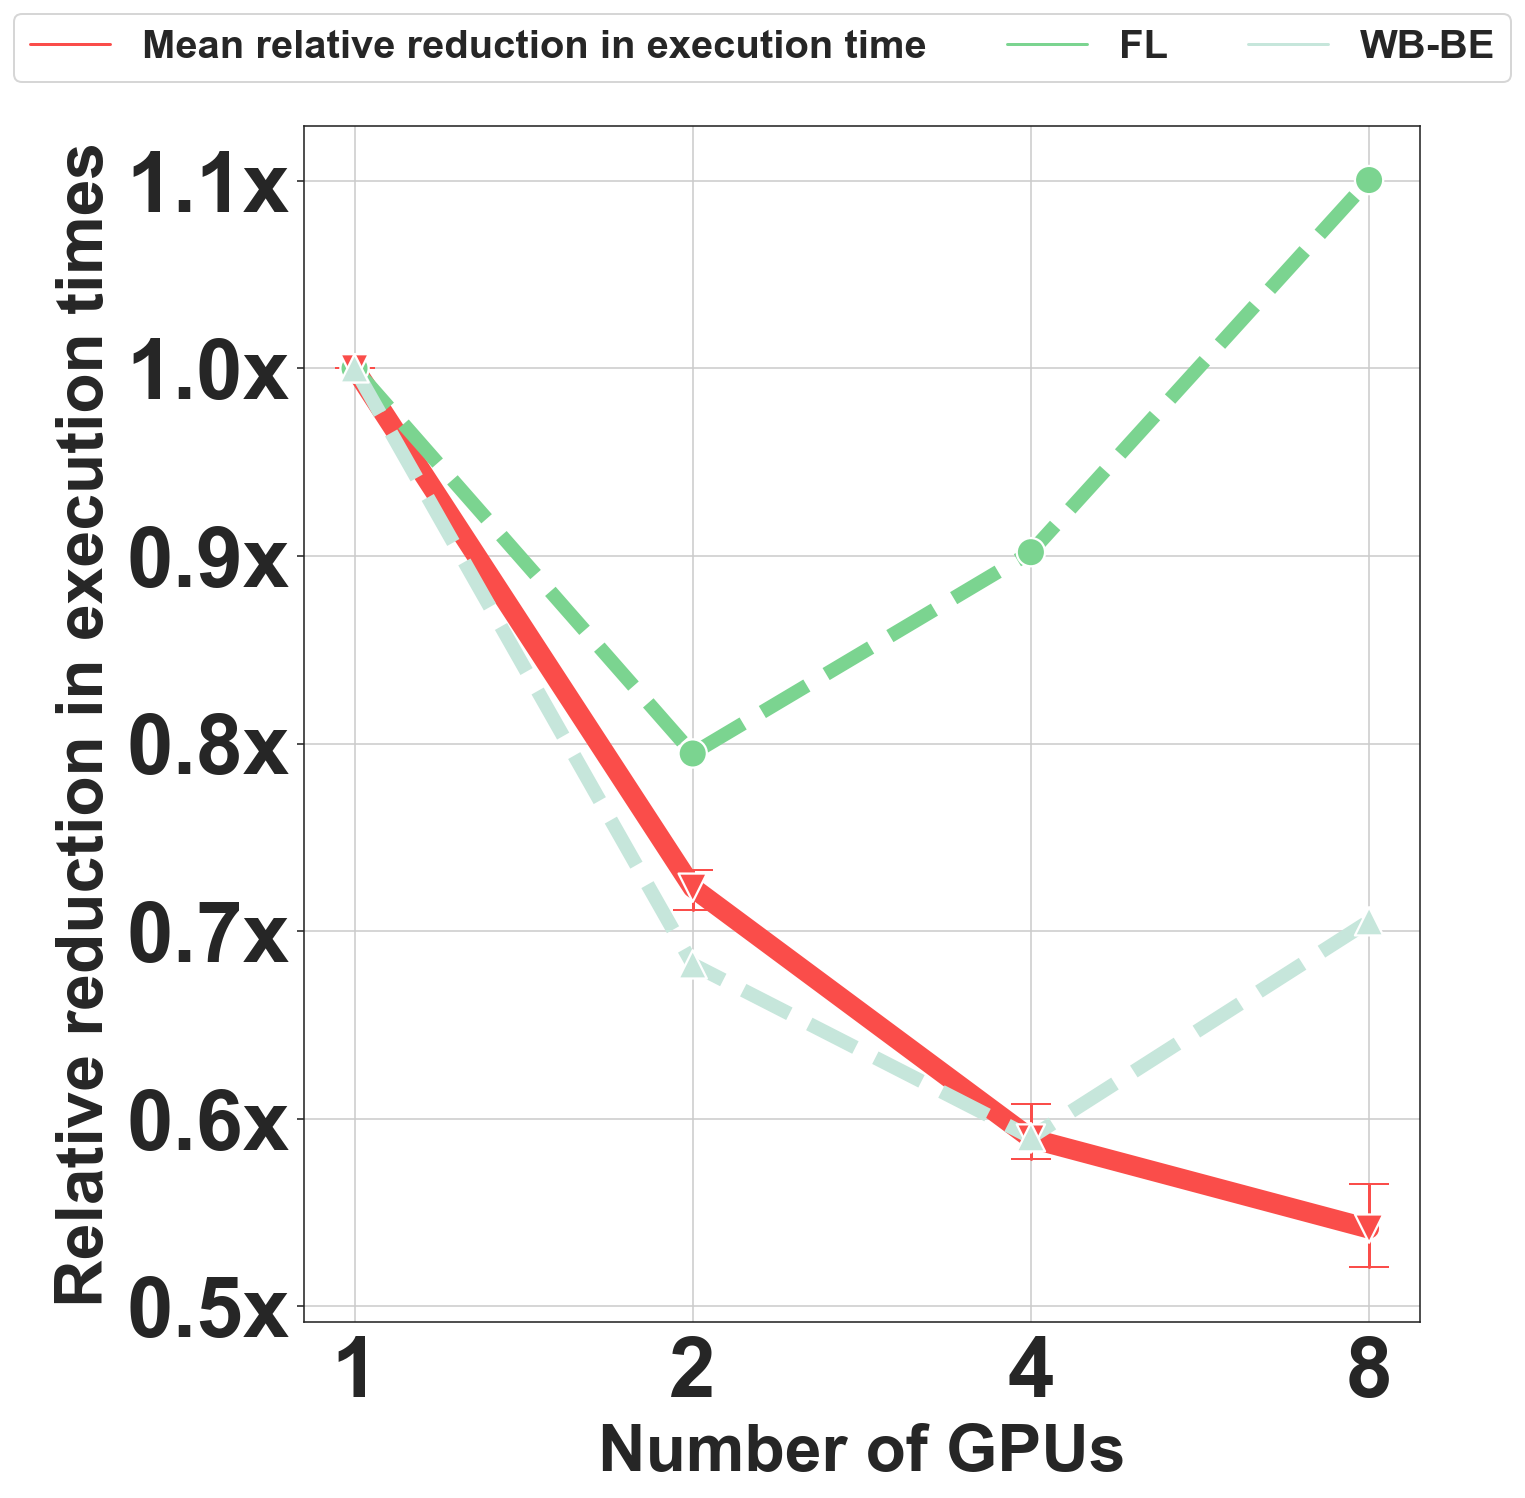

In [469]:
aggregated_exec_times = []
aggregated_speedups = []

outliers = ["FL", "WB-BE"]

plt.figure(figsize=(10,11))
graph_selection = []
for (d_name, gpus), dataset in df_grcuda.groupby(["dataset_name", "gpus"]): 
    aggregated_exec_times.append([d_name, gpus, dataset.execution_time.mean()])

exclude_list = ["WK", "WB-TA"]
    
df_exec_times = pd.DataFrame(aggregated_exec_times, columns=["name", "gpus", "exec_time"])
df_exec_times = df_exec_times[~df_exec_times.name.isin(big_graphs + exclude_list)]
for d_name in df_exec_times.name.unique(): 
    cur_df = df_exec_times[df_exec_times.name == d_name]
    baseline = cur_df[cur_df.gpus == 1].exec_time.iloc[0]
    aggregated_speedups.append([d_name, "1", 1.0])
    
    for gpu_count in [2, 4, 8]: 
        aggregated_speedups.append([d_name, f"{gpu_count}", cur_df[cur_df.gpus == gpu_count].exec_time.iloc[0] / baseline ])

        
mean_aggregated_speedups = []
for e in aggregated_speedups.copy():
    if e[0] not in outliers: 
        mean_aggregated_speedups.append(["Mean relative reduction in execution time", e[1], e[2]])
    else:
        mean_aggregated_speedups.append(e)

df_aggregated_speedups = pd.DataFrame(mean_aggregated_speedups, columns=["name", "gpus", "perc_reduction_exec_time"])
 
ax = sns.lineplot(data=df_aggregated_speedups[df_aggregated_speedups.name == "Mean relative reduction in execution time"], x="gpus", y="perc_reduction_exec_time", hue="name", palette=[COLOR_PALETTE[2]],err_style="bars",err_kws={"capsize": 10.0}, linewidth=10, color="black")
sns.lineplot(data=df_aggregated_speedups[df_aggregated_speedups.name != "Mean relative reduction in execution time"], x="gpus", y="perc_reduction_exec_time", hue="name", palette=COLOR_PALETTE[:2],err_style="bars",err_kws={"capsize": 10.0}, ax=ax, linewidth=7, ls="--")

#ax.legend(title="Graph")
ax.set_ylabel("Relative reduction in execution times", fontsize=33, fontweight="bold"), 
ax.set_xlabel("Number of GPUs", fontsize=33, fontweight="bold")
#ax.set_xticklabels([1, 2, "",4 , "",  "","",  8])
plt.xticks(["1", "2", "4", "8"], weight="bold")
plt.yticks(weight="bold")
plt.legend(title="")
#plt.legend(["Mean relative reduction in execution time", *outliers])

ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}x"))

#ax = sns.scatterplot(x="gpus", y="perc_reduction_exec_time", data=df_aggregated_speedups.groupby(["name", "gpus"]).mean().reset_index(), style="name", palette=[COLOR_PALETTE[2], *COLOR_PALETTE[:2]], legend=False, s=100, zorder=1000)
styles=["o" , "v" , "^"]
cmap = dict(zip(df_aggregated_speedups.name.unique(), COLOR_PALETTE))
CP = [COLOR_PALETTE[0],COLOR_PALETTE[2], COLOR_PALETTE[1],]
for i, (name, df) in enumerate(df_aggregated_speedups.groupby(["name", "gpus"]).mean().reset_index().groupby("name")):  
    sns.scatterplot(x="gpus", y="perc_reduction_exec_time", data=df, style="name", legend=False, zorder=4, s=200, color=CP[i], markers=styles[i], ax=ax)


ax.legend(bbox_to_anchor=(1.1, 1.11), ncol=3, prop={"weight":"bold", "size": 20})

ax.tick_params(axis='y', which='major', labelsize=42)
ax.tick_params(axis='x', which='major', labelsize=42)
ax.grid(True)

plt.savefig("gpu_scaling.pdf",  bbox_inches='tight')


['KRON', 'URAND', 'MOLIERE']

In [431]:
df_acc = pd.read_csv("results_grcuda_orth.csv")
df_acc["dataset_name"] = df_acc["dataset_name"].apply(lambda elem: elem.split("/")[-1].replace(".mtx", ""))
df_acc["type"] = "ORTH"
df_acc = df_acc[df_acc["dataset_name"] != "1138_bus"]
df_acc.head()

,dataset_name,eigen_count,run,lanczos_orth,jacobi_orth,jacobi_reconstr,overall_reconstr,type
100,asia_osm,8,0,4.722663,0,0.000117,5.760713e-08,ORTH
101,asia_osm,8,0,4.734271,0,0.000118,5.773386e-08,ORTH
102,asia_osm,8,1,4.342358,0,0.000189,5.974600e-08,ORTH
103,asia_osm,8,2,4.349358,0,0.000189,5.969051e-08,ORTH
104,asia_osm,8,3,4.333325,0,0.000189,5.972992e-08,ORTH


In [432]:
df_acc_nr = pd.read_csv("./results_grcuda_acc_no_reorth.csv")
df_acc_nr["dataset_name"] = df_acc_nr["dataset_name"].apply(lambda elem: elem.split("/")[-1].replace(".mtx", ""))
df_acc_nr["type"] = "NO_REORTH"
df_acc_nr.head()

,dataset_name,eigen_count,run,lanczos_orth,jacobi_orth,jacobi_reconstr,overall_reconstr,type
0,asia_osm,8,0,6.113418,0,0.000134,4.453265e-07,NO_REORTH
1,asia_osm,8,1,6.088163,0,0.000134,4.433838e-07,NO_REORTH
2,asia_osm,12,0,7.730458,0,0.000126,7.033233e-07,NO_REORTH
3,asia_osm,12,1,7.685502,0,0.000126,7.055459e-07,NO_REORTH
4,asia_osm,16,0,8.113397,0,0.000126,8.614421e-07,NO_REORTH


In [433]:
df_acc = df_acc.append(df_acc_nr)
accuracies = []
for ec, df in df_acc.groupby(["eigen_count"]): 
    accuracies.append([f"{ec}", df.lanczos_orth.to_numpy(), df.overall_reconstr.to_numpy(), df.type.to_numpy()])

In [434]:
unraveled = []
for a, l, re, k in accuracies: 
    for i in range(len(l)): 
        unraveled.append([f"{a}", l[i], re[i], k[i]])
df_u = pd.DataFrame(unraveled, columns=["eigen", "lanczos_orth", "rec_err", "kind"])
df_u["lanczos_orth"] = 90 -  df_u["lanczos_orth"]

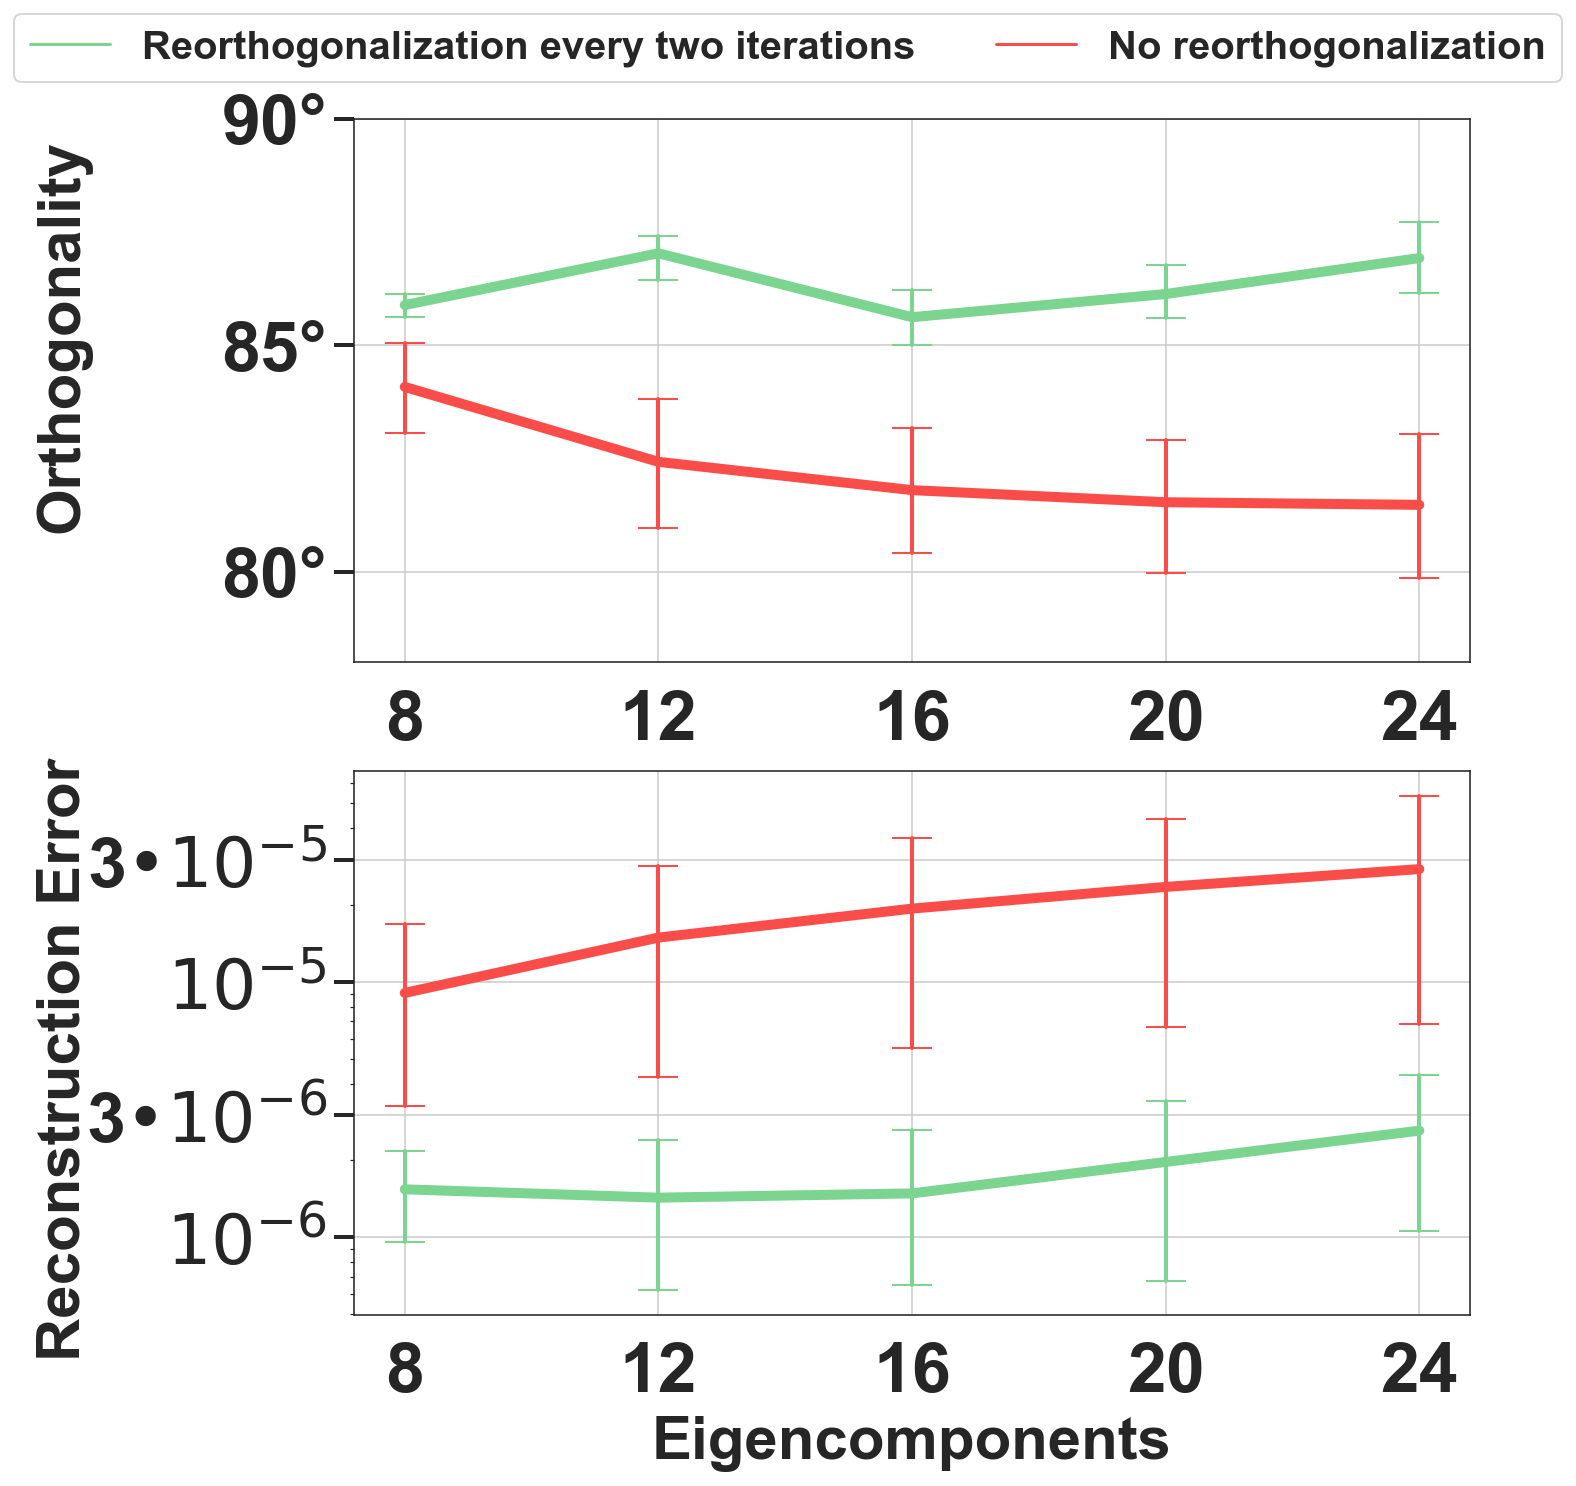

In [458]:
COLOR_PALETTE = ['#7bd490', '#C6E6DB', '#FA4D4A']
fig, axs = plt.subplots(2, figsize=(10,11))

#HERE
sns.lineplot(data=df_u, x="eigen", y="lanczos_orth", hue="kind", palette=[COLOR_PALETTE[0], COLOR_PALETTE[-1]],  estimator="mean",
                      err_style="bars",err_kws={"capsize": 10.0, "elinewidth":2}, linewidth=5, legend=None, sort=False, ci=99, ax=axs[0])
axs[0].set_ylim((78,90))

axs[0].get_yaxis().set_major_formatter(ticker.ScalarFormatter())
axs[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}°", ))


axs[0].grid(True)

kind_form = {
    "ORTH": "Reorthogonalization every two iterations", 
    "NO_REORTH": "No reorthogonalization"
}

df_u["kind_formatted"] = df_u.kind.replace(kind_form)
sns.lineplot(data=df_u, x="eigen", y="rec_err", hue="kind_formatted", palette=[COLOR_PALETTE[0], COLOR_PALETTE[-1]],  estimator="mean",
                      err_style="bars",err_kws={"capsize": 10.0, "elinewidth":2}, linewidth=5, sort=False, ci=99, ax=axs[1])
axs[1].set_yscale("log")
plt.legend(["Reorthogonalization every two iteration", "No reorthogonalization"])
axs[0].set_xlabel( "", fontsize=57)
axs[0].set_ylabel("Orthogonality", fontsize=30,  fontweight="bold")
axs[1].set_ylabel("Reconstruction Error", fontsize=30, weight="bold")
axs[1].set_xlabel("Eigencomponents", fontsize=30,  weight="bold")
axs[1].grid(True)
axs[1].legend(bbox_to_anchor=(1.1, 2.43), ncol=2,prop={"weight":"bold", "size": 20})
axs[1].yaxis.set_tick_params(labelsize=35, width=2, length=10)
axs[1].xaxis.set_tick_params(labelsize=35, width=2, length=10)
axs[0].yaxis.set_tick_params(labelsize=35, width=2, length=10)
axs[0].xaxis.set_tick_params(labelsize=35, width=2, length=10)
c_ticks = []
c_ticks_labels = []


for ii in range(7, 4, -1): 
    c_ticks += [1 * 10**-ii, 3 * 10**-ii]
    c_ticks_labels += [
        "$10^{" + str(-ii) +"}$",
        "3•$10^{" + str(-ii) +"}$",
        #"5•$10^{" + str(-ii) +"}$"
    ]
#axs[1].set_yscale("log")


axs[1].set_yticks(c_ticks[2:])
axs[1].set_yticklabels(c_ticks_labels[2:])
ii = 2
for tick in axs[1].yaxis.get_major_ticks():
    if c_ticks_labels[ii][0] == "2" or c_ticks_labels[ii][0] == "5": 
        tick.label.set_fontsize(20)
        tick.label.set_color("#2d2d2d")
    ii += 1

for ax in axs: 
    for label in ax.get_xticklabels():
        label.set_fontweight(1000)
    for label in ax.get_yticklabels():
        label.set_fontweight(1000)
        
axs[0].yaxis.set_label_coords(-0.235, 0.6)
axs[1].yaxis.set_label_coords(-0.235, 0.47)


plt.savefig("orthogonality_and_reconstruction_error.pdf",  bbox_inches='tight')

In [15]:
df_fpga = pd.read_csv("./results_fpga.csv")
df_fpga["graph_path"] = df_fpga["graph_path"].apply(lambda elem: elem.split("/")[-1].replace(".mtx", ""))
df_fpga["graph_path"] = df_fpga["graph_path"].replace(GRAPH_NAMES)

df_cpu = pd.read_csv("./results_cpu_xeon_platinum.csv")
df_cpu["graph"] = df_cpu["graph"].apply(lambda elem: elem.split("/")[-1].replace(".mtx", ""))
df_cpu["graph"] = df_cpu["graph"].replace(GRAPH_NAMES)

In [437]:
df_fpga["execution_time(ms)"] = df_fpga["lanczos_time"] / 1000
df_cpu["execution_time(ms)"] = df_cpu["execution_time"] * 1000
df_cpu.head()

,graph,vertices,edges,k,run,execution_time,execution_time(ms)
0,IT,6686493,14027956,12,0,106.012417,106012.416601
1,IT,6686493,14027956,12,1,114.689688,114689.687729
2,IT,6686493,14027956,12,2,151.528565,151528.564930
3,IT,6686493,14027956,12,3,144.252949,144252.948999
4,IT,6686493,14027956,12,4,129.074979,129074.978828


In [438]:
execution_times = []
for graph in df_grcuda.dataset_name.unique(): 
    df_graph_fpga = df_fpga[df_fpga.graph_path == graph]
    df_graph_gpu = df_grcuda[df_grcuda.dataset_name == graph]
    df_graph_cpu = df_cpu[df_cpu.graph == graph]


    for i, r in df_graph_fpga.iterrows(): 
        execution_times.append([graph, r.edges,r["execution_time(ms)"], "U280", r["num_eigenvalues"]])
    for i, r in df_graph_gpu.iterrows(): 
        execution_times.append([graph, r.e, r["execution_time(ms)"], "V100", r["eig_count"]])
    for i, r in df_graph_cpu.iterrows(): 
        execution_times.append([graph, r.edges, r["execution_time(ms)"], "XeonPlatinum", r["k"]])


In [439]:
df_execution_times = pd.DataFrame(execution_times, columns=["graph_name", "nnz", "execution_time", "arch", "eig_count"])
#df_execution_times = df_execution_times[(df_execution_times.graph_name != "WB-TA") & (df_execution_times.graph_name != "WK")]

df_execution_times[df_execution_times.graph_name == "URAND"]

,graph_name,nnz,execution_time,arch,eig_count
4286,URAND,4294966740,2.352315e+05,V100,8
4287,URAND,4294966740,2.320296e+05,V100,8
4288,URAND,4294966740,4.317689e+07,XeonPlatinum,8


In [440]:
df_execution_times["speedup"] = 0

exec_times2 = []

for graph in df_execution_times.graph_name.unique(): 
    for eig_count in range(8, 28, 4):
          
        if graph in big_graphs and eig_count != 8: 
            continue
        cpu_selector = (df_execution_times.graph_name == graph) & (df_execution_times.arch == "XeonPlatinum") & (df_execution_times.eig_count == eig_count)
        gpu_selector = (df_execution_times.graph_name == graph) & (df_execution_times.arch == "V100") & (df_execution_times.eig_count == eig_count)
        fpga_selector = (df_execution_times.graph_name == graph) & (df_execution_times.arch == "U280") & (df_execution_times.eig_count == eig_count)
      
        baseline_cpu_ms = df_execution_times[cpu_selector]["execution_time"].mean()
        
        
        if(baseline_cpu_ms == np.nan): 
            continue
        
        exec_times2.append([graph, df_execution_times[gpu_selector]["execution_time"].mean() / 1000, df_execution_times[fpga_selector]["execution_time"].mean() / 1000, df_execution_times[cpu_selector]["execution_time"].mean() / 1000])
        
        df_execution_times.loc[gpu_selector, "speedup"] = baseline_cpu_ms / df_execution_times[gpu_selector]["execution_time"] 
        df_execution_times.loc[fpga_selector, "speedup"] = baseline_cpu_ms / df_execution_times[fpga_selector]["execution_time"] 
        df_execution_times.loc[cpu_selector, "speedup"] = baseline_cpu_ms / df_execution_times[cpu_selector]["execution_time"] 

df_execution_times[(df_execution_times.arch == "XeonPlatinum") & (df_execution_times.graph_name == "HT")]

exec_times_filtered = [a for a in exec_times2 if not np.isnan(a[-1])]
proper_times = pd.DataFrame(exec_times_filtered, columns=["graph", "gpu_time", "fpga_time", "cpu_time"]).groupby("graph").mean().reset_index()


In [441]:
geomean = []


mean_cpu = df_execution_times[(df_execution_times.arch=="XeonPlatinum") ]["execution_time"].mean()
mean_gpu = df_execution_times[(df_execution_times.arch=="V100") ]["execution_time"].mean()
mean_fpga = df_execution_times[(df_execution_times.arch=="U280") ]["execution_time"].mean()

print(mean_cpu, mean_gpu,mean_fpga)

geomean = [
    [
        "GMEAN", 
        0, 
        0,
        "XeonPlatinum", 
        0,
        1.0
    ],
    [
        "GMEAN", 
        0, 
        0,
        "V100", 
        0,
        mean_cpu / mean_gpu
    ], 
    [
        "GMEAN", 
        0, 
        0,
        "U280", 
        0,
        mean_cpu / mean_fpga
    ],
    [
        "GMEAN", 
        0, 
        0,
        "XeonPlatinum", 
        0,
        1.0
    ],
    [
        "GMEAN", 
        0, 
        0,
        "V100", 
        0,
        mean_cpu / mean_gpu
    ], 
    [
        "GMEAN", 
        0, 
        0,
        "U280", 
        0,
        mean_cpu / mean_fpga
    ]
]

df_execution_times = pd.DataFrame(geomean, columns=["graph_name", "nnz", "execution_time", "arch", "eig_count", "speedup"]).append(df_execution_times)
df_execution_times = remove_outliers_df_iqr_grouped(df_execution_times, "speedup", ["arch", "graph_name", "eig_count"], debug=False)

proper_times = proper_times.append(pd.DataFrame([[
        "GMEAN", 
        mean_gpu / 1000, 
        mean_fpga / 1000, 
        mean_cpu / 1000
    ]], columns=["graph", "gpu_time", "fpga_time", "cpu_time"]))

549969.9716225005 8112.023287639745 15585.895533333334


In [442]:
df_execution_times.sort_values("nnz", inplace=True)
df_execution_times["execution_time(s)"] = df_execution_times["execution_time"] / 1000
graphs = df_execution_times["graph_name"].unique()

df_execution_times.loc[(df_execution_times.graph_name == "GMEAN") & (df_execution_times.arch == "XeonPlatinum"), "execution_time(s)"] = mean_cpu / 1000
df_execution_times.loc[(df_execution_times.graph_name == "GMEAN") & (df_execution_times.arch == "V100"), "execution_time(s)"] =  mean_gpu / 1000
df_execution_times.loc[(df_execution_times.graph_name == "GMEAN") & (df_execution_times.arch == "U280"), "execution_time(s)"] =  mean_fpga / 1000

exec_times_agg_s = []



for (graph, arch), df in df_execution_times.groupby(["graph_name", "arch"]): 
    if graph != "GMEAN": 
        cpu_exec = df_execution_times[(df_execution_times.graph_name == graph) & (df_execution_times.arch == "XeonPlatinum")]["execution_time"].mean()
        
        mean_speedup_time = df["speedup"].mean()
        mean_exec_time = df["execution_time"].mean()
        #TODO: here
        exec_times_agg_s.append([graph, arch, mean_exec_time])

gmean_graph = df_execution_times[df_execution_times.graph_name == "GMEAN"]
cpu = gmean_graph[gmean_graph.arch == "XeonPlatinum"]
gpu = gmean_graph[gmean_graph.arch == "V100"]
fpga = gmean_graph[gmean_graph.arch == "U280"]


    
exec_times_agg_s = [
    ["GMEAN", "XeonPlatinum", cpu["execution_time(s)"].mean()],
    ["GMEAN", "U280", fpga["execution_time(s)"].mean()],
    ["GMEAN", "V100", gpu["execution_time(s)"].mean()],
    *exec_times_agg_s
]

#df_exec_times_agg_s = pd.DataFrame(exec_times_agg_s, columns=["graph", "arch", "time"])
graphs = df_execution_times["graph_name"].unique()
graphs
df_execution_times[(df_execution_times.graph_name == "IT") & (df_execution_times.arch == "U280")]

,graph_name,nnz,execution_time,arch,eig_count,speedup,execution_time(s)
1459,IT,14027956,21002.967,U280,20,6.292615,21.002967
1467,IT,14027956,33031.894,U280,24,3.657631,33.031894
1448,IT,14027956,10944.998,U280,12,11.796413,10.944998
1449,IT,14027956,10944.938,U280,12,11.796478,10.944938
1450,IT,14027956,10944.912,U280,12,11.796506,10.944912
1451,IT,14027956,10944.888,U280,12,11.796532,10.944888
1453,IT,14027956,15674.007,U280,16,9.891812,15.674007
1454,IT,14027956,15673.968,U280,16,9.891837,15.673968
1455,IT,14027956,15673.946,U280,16,9.891851,15.673946
1456,IT,14027956,15673.931,U280,16,9.891860,15.673931


/Users/lnghrdntcr/opt/anaconda3/envs/native/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/lnghrdntcr/opt/anaconda3/envs/native/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/lnghrdntcr/opt/anaconda3/envs/native/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lnghrdntcr/opt/anaconda3/envs/native/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values

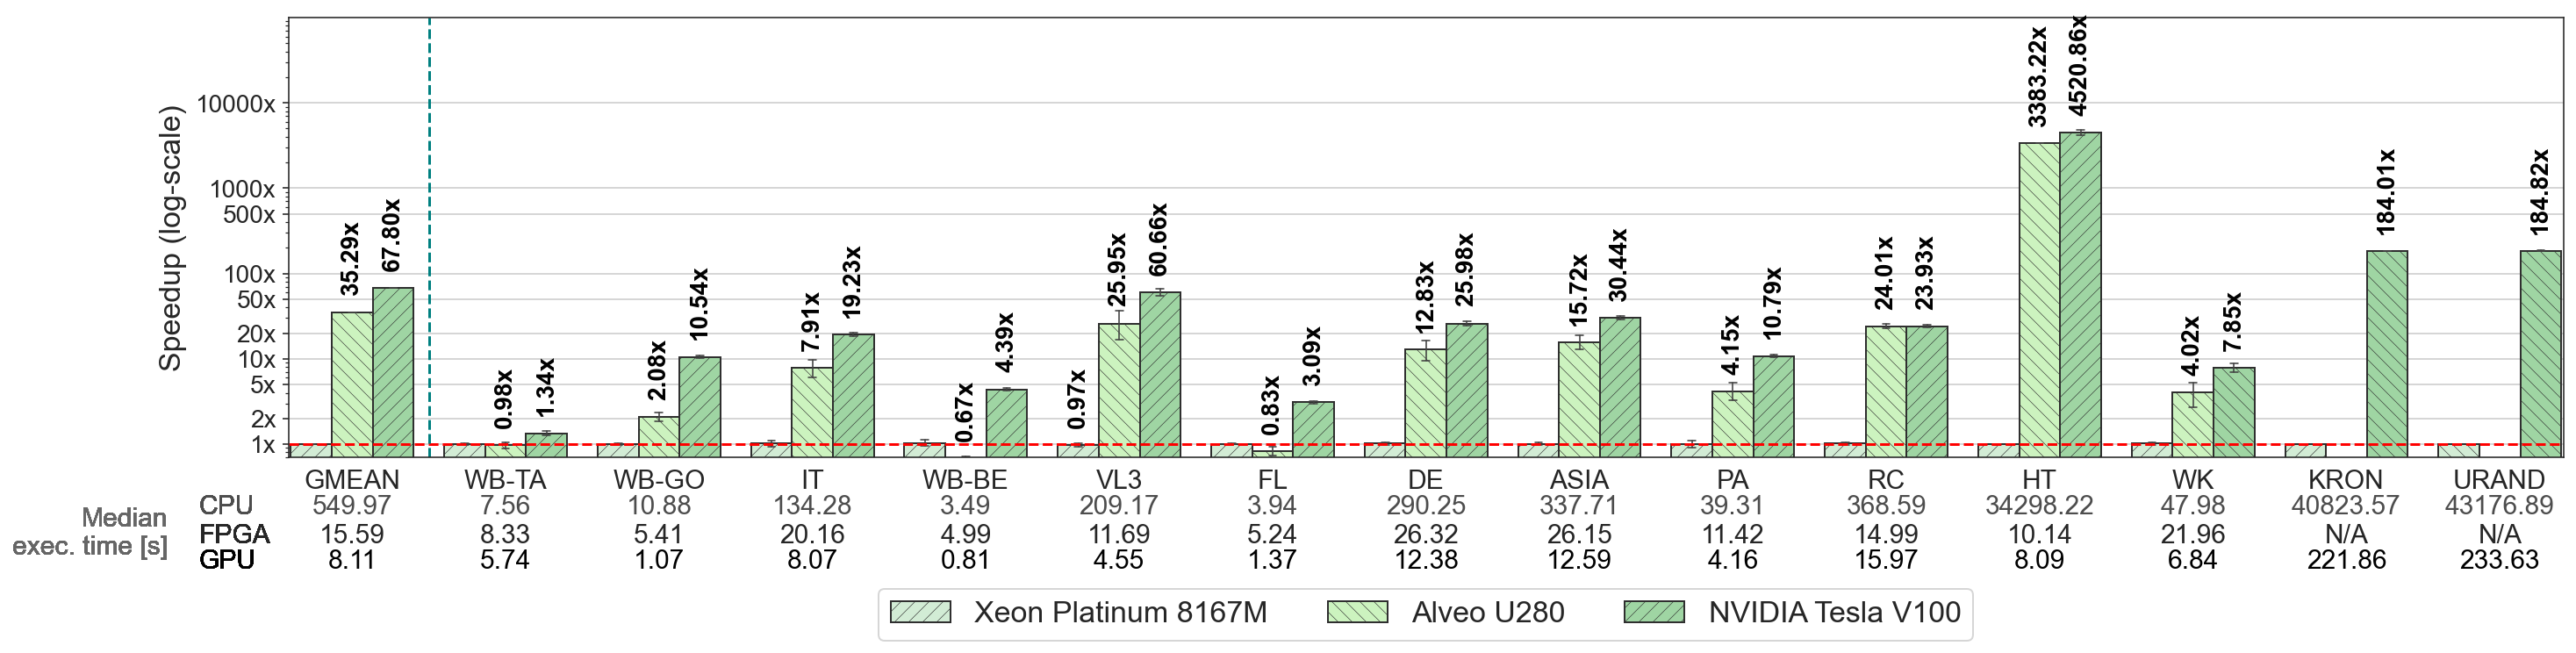

In [443]:
TEXT_PALETTE = ["#4d4d4d", "#262626", "#000000"]

fig = plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(1, 1)
plt.subplots_adjust(top=0.97,
                    bottom=0.39,
                    left=0.08,
                    right=0.98,
                    hspace=1.0,
                    wspace=0.8)  
ax = fig.add_subplot(gs[0, 0])

arch_rename_map = dict(zip(["XeonPlatinum", "U280", "V100"], ["Xeon Platinum 8167M", "Alveo U280", "NVIDIA Tesla V100"]))

df_execution_times["arch_ext"] = df_execution_times["arch"].replace(arch_rename_map)

ax = sns.barplot(data=df_execution_times, x="graph_name", y="speedup", ci=99, hue="arch_ext", palette=PALETTE_B, ax=ax,capsize=.05, errwidth=0.8, edgecolor="#2f2f2f",hue_order=["Xeon Platinum 8167M", "Alveo U280", "NVIDIA Tesla V100"])
#ax = sns.barplot(data=df_execution_times, x="graph_name", y="execution_time", ci=99, hue="arch",palette=PALETTE_B, ax=ax,capsize=.05, errwidth=0.8, edgecolor="#2f2f2f",)


plt.legend(title="Platform")
ax.set_xlabel("", fontsize=15)
_ = ax.set_ylabel("Speedup (log-scale)", fontsize=17)
num_benchmarks = len(df_grcuda.dataset_name.unique())
for j, bar in enumerate([p for p in ax.patches if not pd.isna(p)]):
    bar.set_hatch(HATCHES[j // num_benchmarks])



ax.set_yscale('log')
plt.yticks(list(plt.yticks()[0]) + [1.0])
ax.axhline(1.0, ls="--", color="red")
plt.axvline(x=0.5, ls="--", color="teal")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.rcParams['legend.fontsize'] = 17
ax.set_ylim((0.7, 100000)) 


ax.set_yticks([1, 2, 5, 10, 20, 50, 100, 500, 1000, 10000])
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}x"))

ax.tick_params(axis='y', which='major', labelsize=14)
ax.grid(True, axis="y")

offsets = []
for k, g in df_execution_times.groupby(["graph_name", "arch_ext"], sort=False):
    co = get_upper_ci_size(g["speedup"], ci=0.99)
    if np.isnan(co): 
        co = g["speedup"].mean()
    offsets += [co]
    #print(offsets[-1])

#offsets = [max(o, 0.3) for o in offsets]


#add_labels(ax, vertical_offsets=offsets,rotation=90, format_str="{:.2f}x", fontsize=13, skip_zero=False, skip_value=1, skip_threshold=0.04)
labels = [p.get_height() for p in ax.patches]
for i, p in enumerate(ax.patches): 
    if 0.98 < p.get_height() < 1.04: 
        continue
        
    scale = p.get_height() / 1.7
    ax.text(p.get_x() + p.get_width()/2., scale + p.get_height(), "{:.2f}x".format(labels[i]), fontsize=14, color="black", ha='center', va='bottom', rotation=90, weight="bold")

plt.margins(x=0.001, y=0.001) 


FORBIDDEN_SET = []
group_length = 3

#print mean execution times for each graph below
for i in range(len(ax.patches) // group_length):
    if i not in FORBIDDEN_SET:
        y_min = 0.6
        y_max = 0.45
        x_middle = (ax.patches[i].get_x() + ax.patches[i].get_x() + group_length * ax.patches[i].get_width()) / 2
        fpga_time = proper_times[(proper_times.graph == graphs[i])]['fpga_time'].mean()
        if np.isnan(fpga_time): 
            fpga_time = "N/A"
        else: 
            fpga_time = f"{(fpga_time):.2f}"
        #ax.plot([ax.patches[i].get_x(), ax.patches[i].get_x() + group_length * ax.patches[i].get_width()], [y_min, y_min], clip_on=False, color="#2f2f2f", linewidth=1)
        #ax.plot([x_middle, x_middle], [y_min, y_max], clip_on=False, color="#2f2f2f", linewidth=1)
        # Also add median execution time;
        ax.text(x_middle, 0.15, f"{(proper_times[(proper_times.graph == graphs[i])]['cpu_time'].mean()):.2f}", fontsize=15, color=TEXT_PALETTE[0], ha="center")
        ax.text(x_middle, 0.07, fpga_time, fontsize=15, color=TEXT_PALETTE[1], ha="center")
        ax.text(x_middle, 0.035, f"{(proper_times[(proper_times.graph == graphs[i])]['gpu_time'].mean()):.2f}", fontsize=15, color=TEXT_PALETTE[2], ha="center")


        j += 1
    ax.text(-1.2, 0.09, "Median\nexec. time [s]", fontsize=15, color="#666666", ha="right", va="center")
    ax.text(-1, 0.15, "CPU", fontsize=15, color=TEXT_PALETTE[0], ha="left")
    ax.text(-1, 0.07, "FPGA", fontsize=15, color=TEXT_PALETTE[1], ha="left")
    ax.text(-1, 0.035, "GPU", fontsize=15, color=TEXT_PALETTE[2], ha="left")


ax.legend(bbox_to_anchor=(0.50, -0.45), ncol=3)



plt.savefig("speedup.pdf", bbox_inches='tight')


In [444]:
## bubble plots of accuracy vs execution time
graph_properties = {}

for graph, df in df_grcuda.groupby("dataset_name"): 
    graph_properties[graph] = [
        *df.iloc[1, 1:4]
    ]

def scale(eigen_count, graph_name): 
    gp = graph_properties[graph_name]
    return gp[1] + 2 * gp[0] + (eigen_count - 1) * (4 * gp[0] + gp[1]) + 2 * eigen_count**2 * gp[1]

dataset_to_use = [ 'WB-BE', 'WB-GO','PA', 'HT', 'VL3', 'IT']
df_mp_ddd = pd.read_csv("./results_grcuda_all_double_double_double.csv")
df_mp_ddd["dataset_name"] = df_mp_ddd["dataset_name"].apply(lambda elem: elem.split("/")[-1].replace(".mtx", ""))
df_mp_ddd["dataset_name"] = df_mp_ddd["dataset_name"].replace(GRAPH_NAMES)
df_mp_ddd["normalized_execution_time"] = df_mp_ddd.apply(lambda row: row["execution_time"] / scale(row["eigen_count"], row["dataset_name"]), axis=1)
df_mp_ddd = df_mp_ddd[df_mp_ddd.dataset_name.isin(dataset_to_use)]
df_mp_ddd["overall_reconstr"] /= df_mp_ddd["eigen_count"]
#df_mp_ddd["dataset_name"] = df_mp_ddd["dataset_name"].apply(lambda x: x + " double double double")
df_mp_ddd["datatype"] = "double double double"
#scale(row["eigen_count"], row["dataset_name"])

df_mp_fdf = pd.read_csv("./results_grcuda_all_float_float_double.csv")
df_mp_fdf["dataset_name"] = df_mp_fdf["dataset_name"].apply(lambda elem: elem.split("/")[-1].replace(".mtx", ""))
df_mp_fdf["dataset_name"] = df_mp_fdf["dataset_name"].replace(GRAPH_NAMES)
df_mp_fdf["normalized_execution_time"] = df_mp_fdf.apply(lambda row: row["execution_time"] / scale(row["eigen_count"], row["dataset_name"]), axis=1)
df_mp_fdf = df_mp_fdf[df_mp_fdf.dataset_name.isin(dataset_to_use)]
df_mp_fdf["overall_reconstr"] /= df_mp_fdf["eigen_count"]
#df_mp_fdf["dataset_name"] = df_mp_fdf["dataset_name"].apply(lambda x: x + " float double float")
df_mp_fdf["datatype"] = "float double float"


df_mp = df_mp_fdf.append(df_mp_ddd)
#df_mp = remove_outliers_df_iqr_grouped(df_mp, "overall_reconstr", ["kind"])
#df_mp = remove_outliers_df_iqr_grouped(df_mp, "normalized_execution_time", ["kind"])

In [445]:
df_grcuda["normalized_execution_time"] = df_grcuda.apply(lambda row: row["execution_time"] * 1000 / scale(row["eig_count"], row["dataset_name"]), axis=1)
df_grcuda["datatype"] = "float float float"

df_acc_nr["dataset_name"] = df_acc_nr["dataset_name"].replace(GRAPH_NAMES)
df_acc["dataset_name"] = df_acc["dataset_name"].replace(GRAPH_NAMES)

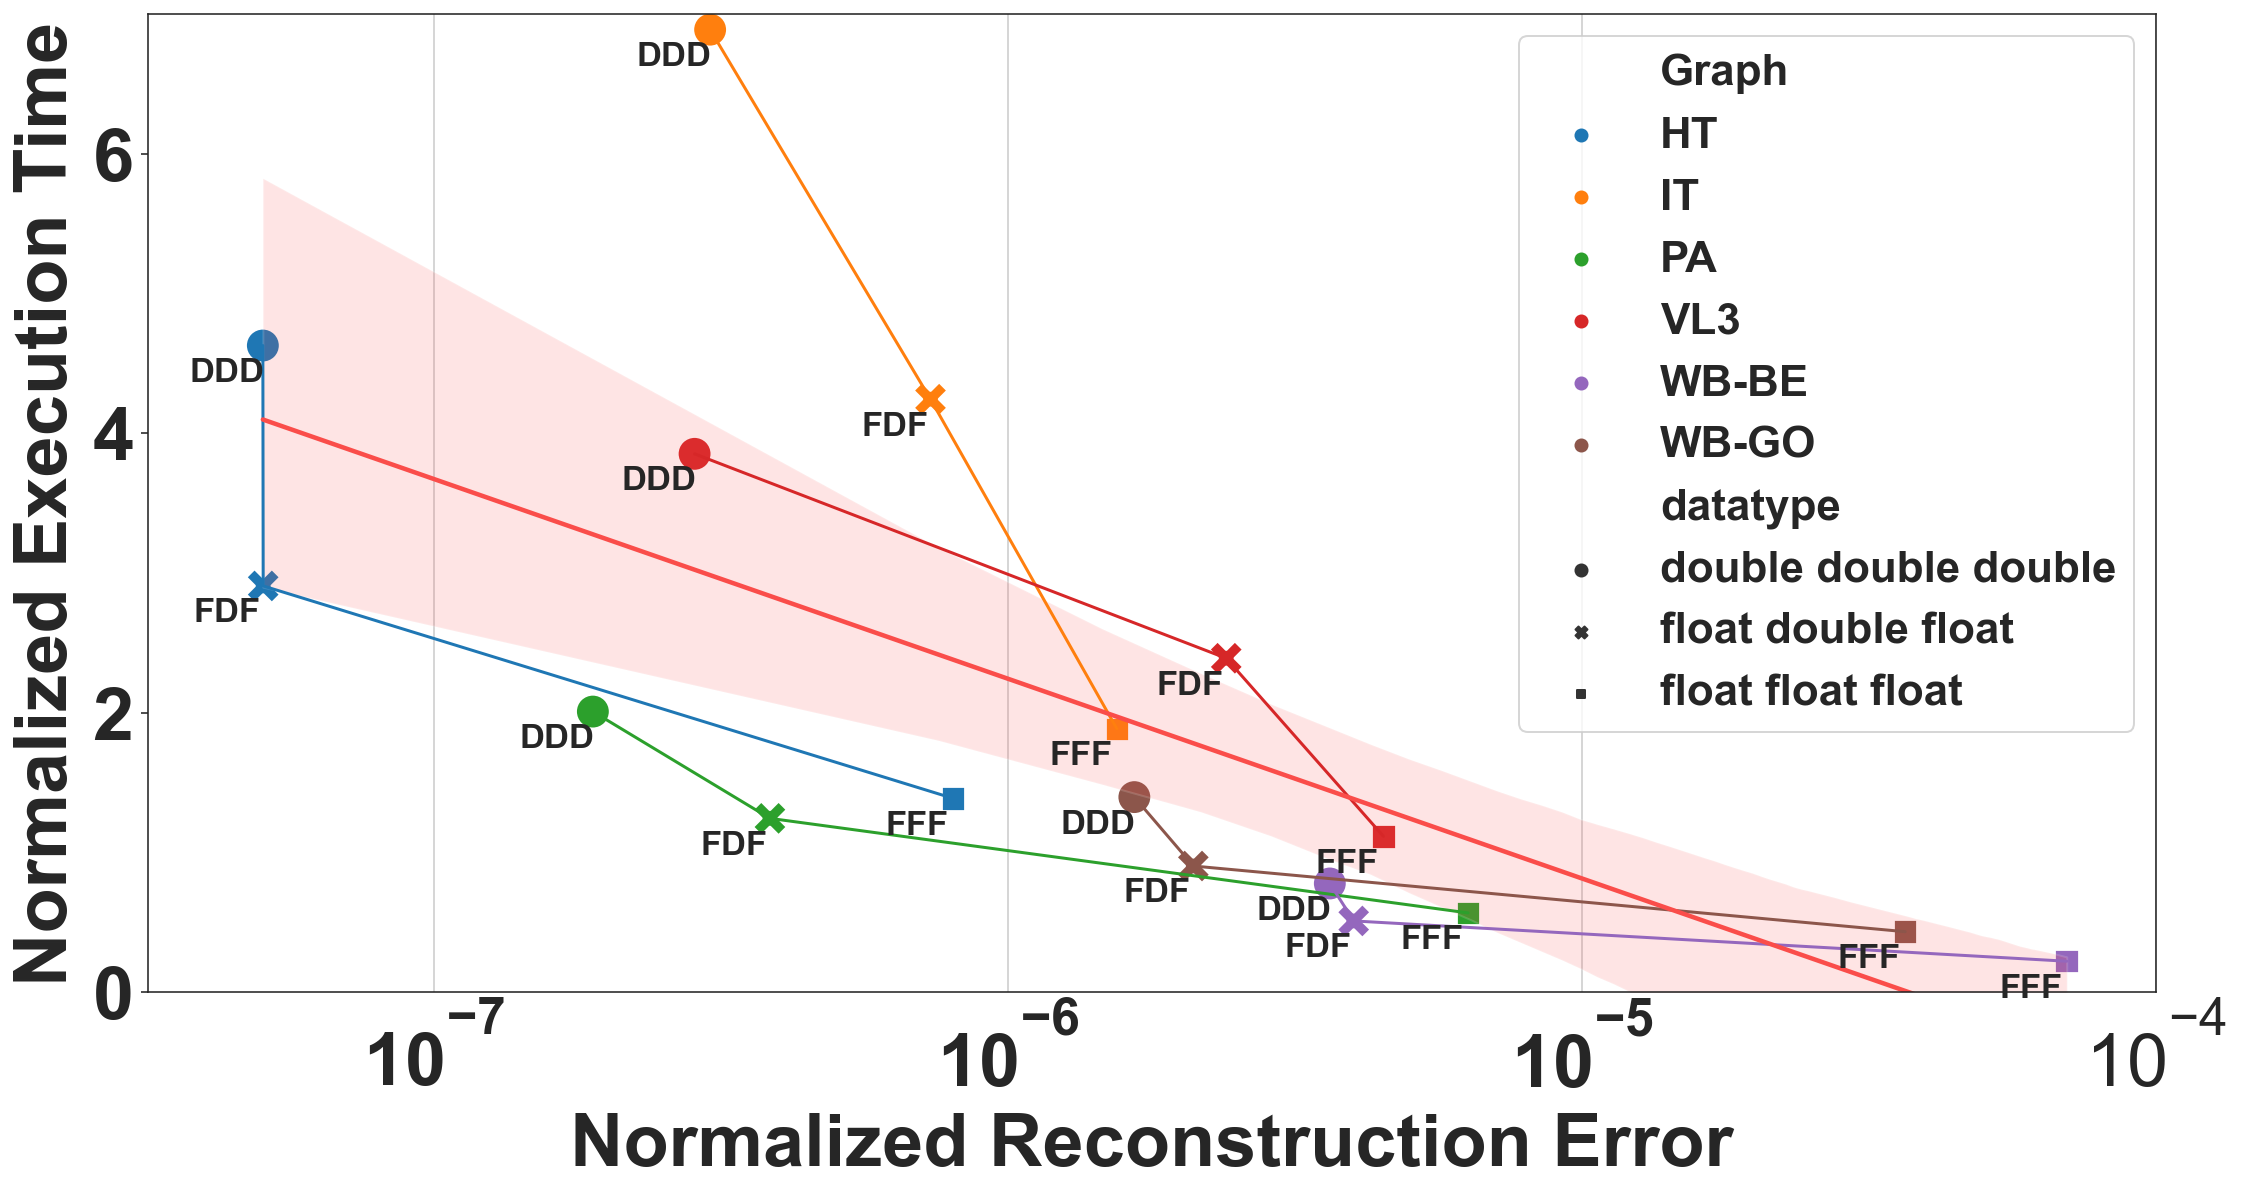

In [457]:
#plt.figure(figsize=(20, 12))
plt.figure(figsize=(18, 9))
agg = []
for(name, dtype), df in df_mp.groupby(["dataset_name", "datatype"]): 
    #print(name, df["normalized_execution_time"].mean(), df["overall_reconstr"].mean())
    agg.append([name, df["overall_reconstr"].mean(), df["normalized_execution_time"].mean(), dtype])
    
for name, df in df_mp.groupby(["dataset_name"]): 
    gc = df_grcuda[df_grcuda.dataset_name == name]
    nr = df_acc_nr[df_acc_nr.dataset_name == name]
    exec_time = gc["normalized_execution_time"].mean()
    reconstr_accuracy = nr["overall_reconstr"].mean()
    agg.append([name, reconstr_accuracy, exec_time, "float float float"])
    #print(agg[-1])


df_mp_agg = pd.DataFrame(agg, columns=["dataset_name", "overall_reconstr", "normalized_execution_time", "datatype"])
#df_mp_agg["overall_reconstr"] = np.log10(df_mp_agg["overall_reconstr"])


legend_items = []
for graph, df in df_mp_agg.groupby("dataset_name"): 

    sns.lineplot(x=df["overall_reconstr"], y=df["normalized_execution_time"])


#df_mp.groupyby("dataset_name").plot(x="overall_recons§tr", y="normalized_execution_time", kind="scatter")
df_mp_agg["Graph"] = df_mp_agg["dataset_name"]

ax = sns.scatterplot(data=df_mp_agg, x="overall_reconstr", y="normalized_execution_time", hue="Graph", style="datatype", s=300)
sns.regplot(data=df_mp_agg[["overall_reconstr", "normalized_execution_time"]], 
            x="overall_reconstr",
            y="normalized_execution_time", 
            ax=ax, 
            truncate=True, 
            n_boot=1000,
            scatter=False, 
            ci=95,
            logx=True,
            #order=2,
            #robust=True, 
            #logistic=True, NO
            #lowess=True,
            color=COLOR_PALETTE[2],
            #line_kws={"linewidth": 0.8, "linestyle": "--", "zorder": -1},
            #x_jitter=10**-7,
            #y_jitter=10
           )


rename_map = {
    "float float float": "FFF", 
    "float double float": "FDF", 
    "double double double": "DDD"
}

fontdict={
    "fontsize": "x-large"
}
xytext=(-18,-18)
for name, df in df_mp_agg.groupby("dataset_name"): 
    for i, el in df.iterrows(): 
        ax.annotate(rename_map[el["datatype"]], xy=(el['overall_reconstr'], el['normalized_execution_time']), textcoords="offset points", ha="center",xytext=xytext, fontsize="xx-large", fontweight=1000)

ax.grid(True, axis="x")


ticks = []
labels = []
for i in range(4, 9): 
    tmp = []
    for j in [5, 2, 1]: 
        if i == 4 and j != 1: 
            continue
        if j == 1: 
            tmp.append(j * 10**-i)
            labels.append("$" + "10^{-" + str(i) + "}" + "$")
        
    ticks += [*tmp]
plt.xticks(ticks=ticks[::-1], labels=labels[::-1], weight="bold")
plt.yticks(weight="bold")

ax.set_xlim((10**-7.5, 10**-4))
ax.set_ylim((0, 7))

df_mp_agg.to_csv("pareto.csv", index=False)

ax.tick_params(axis='x', which='both', labelsize=37)
ax.tick_params(axis='y', which='both', labelsize=37)

ax.set_xlabel("Normalized Reconstruction Error", fontsize=37, weight="bold")
ax.set_ylabel("Normalized Execution Time", fontsize=37, weight="bold")
ax.set_xscale("log")
plt.legend(prop={"weight":"bold", "size": 22})


plt.savefig("pareto.pdf",  bbox_inches='tight')


In [447]:
df_mp_agg

,dataset_name,overall_reconstr,normalized_execution_time,datatype,Graph
0,HT,5.022766e-08,4.627874,double double double,HT
1,HT,5.029453e-08,2.908020,float double float,HT
2,IT,3.021611e-07,6.887615,double double double,IT
3,IT,7.314841e-07,4.244000,float double float,IT
4,PA,1.887753e-07,2.009162,double double double,PA
5,PA,3.841057e-07,1.245284,float double float,PA
6,VL3,2.838941e-07,3.853059,double double double,VL3
7,VL3,2.395879e-06,2.390731,float double float,VL3
8,WB-BE,3.630442e-06,0.779417,double double double,WB-BE
9,WB-BE,3.995522e-06,0.511475,float double float,WB-BE


In [448]:
improvements = []

for graph, df in df_mp_agg.groupby("dataset_name"): 
    baseline = df[df.datatype == "float float float"][["overall_reconstr", "normalized_execution_time"]].to_numpy()
    fdf =  df[df.datatype == "float double float"][["overall_reconstr", "normalized_execution_time"]].to_numpy()
    ddd = df[df.datatype == "double double double"][["overall_reconstr", "normalized_execution_time"]].to_numpy()
    improvements.append(["fdf", baseline[0][0] / fdf[0][0], baseline[0][1] / fdf[0][1]])
    improvements.append(["ddd", baseline[0][0] / ddd[0][0], baseline[0][1] / ddd[0][1]])    
    improvements.append(["fdf VS ddd", fdf[0][0] / ddd[0][0], fdf[0][1] / ddd[0][1]])

In [449]:
df_impr = pd.DataFrame(improvements, columns=["kind", "overall_reconstr", "execution_time"])

In [450]:
print("fdf / ddd\n", df_impr[df_impr.kind=="fdf VS ddd"].mean())


fdf / ddd
 overall_reconstr    2.710637
execution_time      0.631380
dtype: float64


In [451]:
ddd_rec = df_mp_agg[df_mp_agg.datatype == "double double double"].overall_reconstr.mean()
fdf_rec = df_mp_agg[df_mp_agg.datatype == "float double float"].overall_reconstr.mean()
fff_rec = df_mp_agg[df_mp_agg.datatype == "float float float"].overall_reconstr.mean()

print("reconstruction error fff / fdf = ", fff_rec / fdf_rec)
print("reconstruction error fff / ddd = ", fff_rec / ddd_rec)

reconstruction error fff / fdf =  12.373912296515558
reconstruction error fff / ddd =  19.54857480269293


In [452]:
ddd_et = df_mp_agg[df_mp_agg.datatype == "double double double"].normalized_execution_time.mean()
fdf_et = df_mp_agg[df_mp_agg.datatype == "float double float"].normalized_execution_time.mean()
fff_et = df_mp_agg[df_mp_agg.datatype == "float float float"].normalized_execution_time.mean()

print("Execution time fff / fdf = ", fff_et / fdf_et)
print("Execution time fff / ddd = ", fff_et / ddd_et)

Execution time fff / fdf =  0.46030844754626044
Execution time fff / ddd =  0.28727757920878316


In [453]:
print("RE", 1 / (fdf_rec / ddd_rec))
print("ET", 1 / (fdf_et / ddd_et))

RE 0.6329828348822125
ET 1.6023124700996059


In [454]:
549969 / 8112

67.7969674556213